In [1]:
import numpy as np

# Среднеквадратичная ошибка - для оценки работы алгоритма
def mse(A: np.ndarray, B: np.ndarray):
    minlen = min(len(A), len(B))

    return np.nanmean((A[:minlen] - B[:minlen]) ** 2)

# Для подсчета MSE надо бы иметь последовательности одинаковой длины
def expand(A: np.ndarray, times: int = 2):
    return np.array(
        list(
            e
            for elem in A
            for e in [elem] * times
        )
    )

# Позволит групировать последовтельность по N последовательных элементов
def grouper(n, iterable):
    args = [iter(iterable)] * n
    return zip(*args)

# Матрица хаара для наименьшего шага преобразования
H2 = np.array(
    [[1, 1], [1, -1]]
) * 1/2

# Шаг фильтрации хаара для одномерной последовательности
def h_filter(sequence: np.ndarray):
    res = list(np.dot(chunk, H2) for chunk in grouper(2, sequence))

    return np.transpose(res)


def multi_h_filter(n, x, y):
    for _ in range(n):
        x, _ = h_filter(x)
        y, _ = h_filter(y)

        print(len(x), len(y))
    
    return x, y

400 400


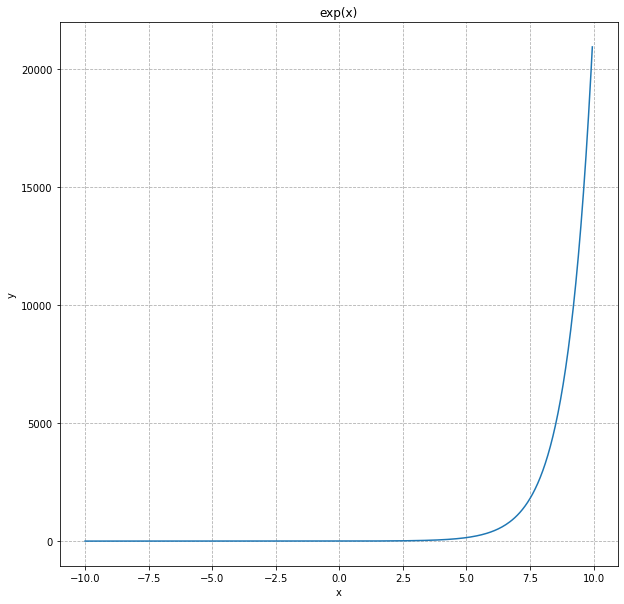

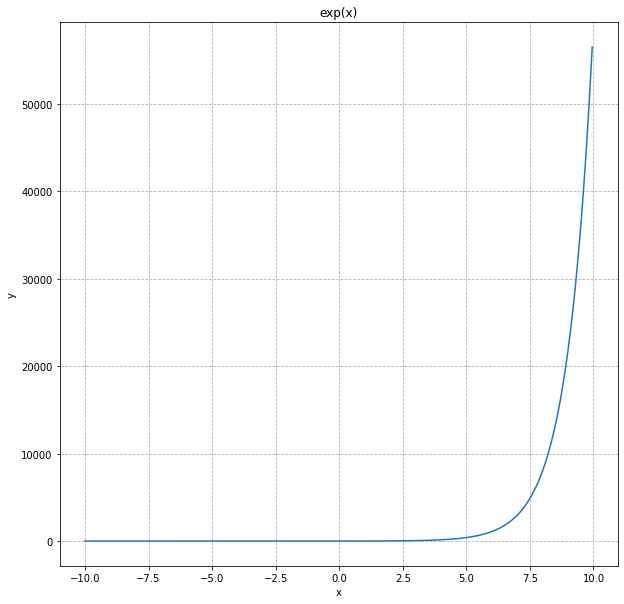

200 200
100 100
50 50
25 25
200 200
100 100
50 50
25 25


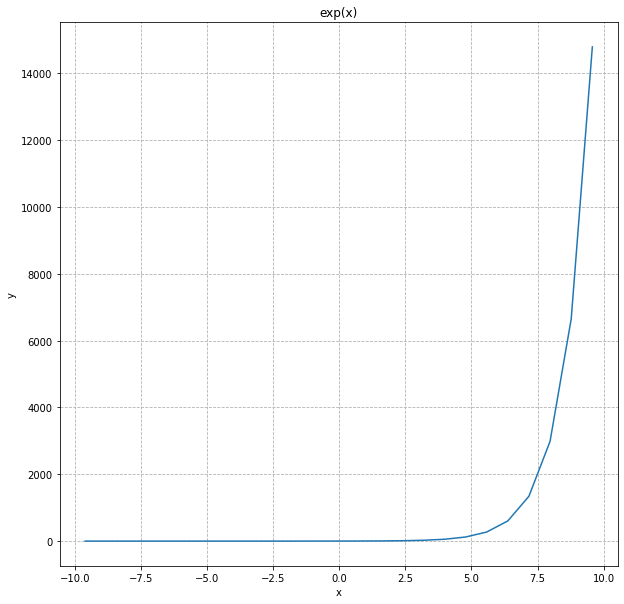

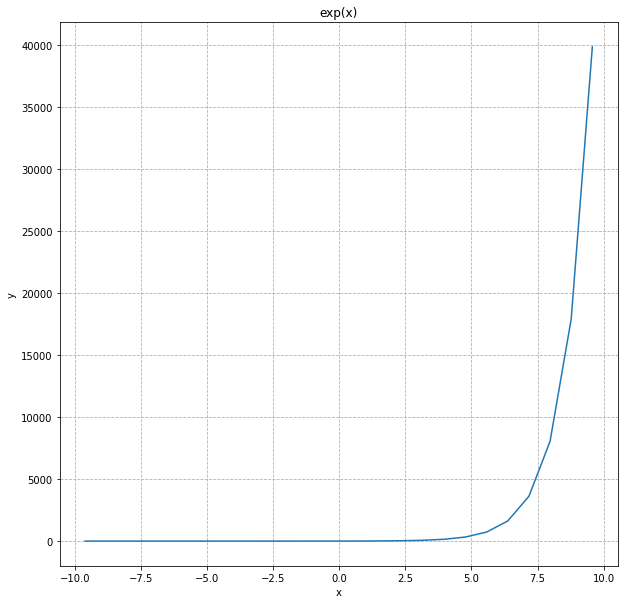

In [9]:
import matplotlib.pyplot as plt

x = np.arange(-10, 10, 0.05)
y = np.exp(x)
noise = np.random.uniform(1.0, 10.0)
ny = noise * y + noise
n = 4

def plotexp(x, y):
    plt.figure(figsize=(10, 10))
    plt.title("exp(x)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x, y)
    plt.grid(linestyle='--')
    plt.show()

print(len(x), len(y))

plotexp(x, y)
plotexp(x, ny)

fx, fy = multi_h_filter(n, x, y)
fx, nfy = multi_h_filter(n, x, ny)

plotexp(fx, fy)
plotexp(fx, nfy)